# Cosmology sampling of cosmographic posteriors
This notebook leads you through a sampling of multiple lenses with two dimensional angular diameter distance posteriors.
We first generate a set of posteriors for different lenses for a given cosmology and then sample cosmological model posteriors from this generated mock data set.

In [1]:
# some standard python imports #
import copy
import numpy as np
import corner
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(seed=41)

In [2]:
# lenstronomy and astropy modules

from lenstronomy.Cosmo.lens_cosmo import LensCosmo
from hierarc.Sampling.mcmc_sampling import MCMCSampler
from astropy.cosmology import FlatLambdaCDM

# define a cosmology
H0_true = 70
omega_m_true = 0.3
cosmo = FlatLambdaCDM(H0=H0_true, Om0=omega_m_true)

In [5]:
# define lenses and their uncertainties in the posterior (uncorrelated)
lens_setting_list = [{'z_lens': 0.8, 'z_source': 3.0, 'sigma_dt': 0.07, 'sigma_dd': 0.15},
                     {'z_lens': 0.3, 'z_source': 1.1, 'sigma_dt': 0.07, 'sigma_dd': 0.15},
                     {'z_lens': 0.5, 'z_source': 1.7, 'sigma_dt': 0.07, 'sigma_dd': 0.15}
                    ]

bandwidth = 2
num_samples = 10000  # number of posterior points to be sampled
kde_type = 'scipy_gaussian'  # 'gaussian', 'epanechnikov', 'scipy_gaussian'

kwargs_lens_list = []
for lens_setting in lens_setting_list:
    z_lens = lens_setting['z_lens']
    z_source = lens_setting['z_source']
    sigma_dd = lens_setting['sigma_dd']
    sigma_dt = lens_setting['sigma_dt']
    lensCosmo = LensCosmo(z_lens, z_source, cosmo=cosmo)

    Dd_mean = np.random.normal(lensCosmo.dd, sigma_dd * lensCosmo.dd)
    Ddt_mean = np.random.normal(lensCosmo.ddt, sigma_dt * lensCosmo.ddt)

    
    D_dt_samples = np.random.normal(Ddt_mean, sigma_dt * lensCosmo.ddt, num_samples)
    D_d_samples = np.random.normal(Dd_mean, sigma_dd * lensCosmo.dd, num_samples)
    kwargs_lens_list.append({'z_lens': z_lens, 'z_source': z_source, 'likelihood_type': 'DdtDdKDE',
                             'dd_samples': D_d_samples,
                       'ddt_samples': D_dt_samples, 'kde_type': kde_type, 'bandwidth': bandwidth})

100%|██████████| 200/200 [02:54<00:00,  1.74it/s]


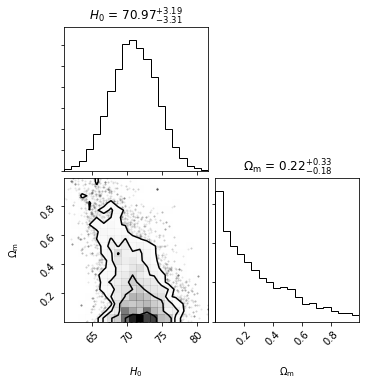

In [6]:
cosmology = 'FLCDM'  # available models: 'FLCDM', "FwCDM", "w0waCDM", "oLCDM"
# parameters are: 'h0', 'om', 'ok', 'w', 'w0', 'wa'

n_walkers = 100
n_run = 100
n_burn = 100

kwargs_mean_start = {'kwargs_cosmo': {'h0': 70, 'om': 0.3},
                     'kwargs_lens': {},
                     'kwargs_kin': {}}

kwargs_sigma_start = {'kwargs_cosmo': {'h0': 10, 'om': 0.1},
                     'kwargs_lens': {},
                     'kwargs_kin': {}}


kwargs_bounds = {'kwargs_lower_cosmo': {'h0': 1, 'om': 0},
                'kwargs_lower_lens': {},
                'kwargs_lower_kin': {},
                'kwargs_upper_cosmo': {'h0': 200, 'om': 1},
                'kwargs_upper_lens': {},
                'kwargs_upper_kin': {},
                'kwargs_fixed_cosmo': {},
                'kwargs_fixed_lens': {},
                'kwargs_fixed_kin': {}}

mcmc_sampler = MCMCSampler(kwargs_lens_list, cosmology, kwargs_bounds)
mcmc_samples, log_prob_cosmo = mcmc_sampler.mcmc_emcee(n_walkers, n_run, n_burn, kwargs_mean_start, kwargs_sigma_start)

corner.corner(mcmc_samples, show_titles=True, labels=mcmc_sampler.param_names(latex_style=True))
plt.show()

